## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [1]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, "efficientnetb5_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", "efficientnetb5")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 15:46:44,023	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-18 15:46:44,210	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

Using device: CUDA (GPU)


## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [ ]:
# DATA_DIR = "../input/final_split_training_augmented"
# ZIP_URL = "https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr"
# ZIP_FILENAME = "../input/final_split.zip"
# ROOT_DIR = "../input"

# download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

Dataset already exists at ../input/final_split_training_augmented


## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [3]:
SPLIT_DATASET = os.path.abspath("../../input/final_split_15Apr2025")
BATCH_SIZE = 64

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    weights.transforms()
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [4]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications
This is where you should replace with your model.

EfficientNetB5 Partial Transfer Learning:
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 

In [5]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class BaseEfficientNetB5(nn.Module):
    """
    EfficientNetB5 with optional SE block and configurable classifier for Ray Tune.
    """
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None) -> None:
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features

        for param in self.backbone.features.parameters():
            param.requires_grad = False

        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Build the classifier head
        layers = []
        if use_se:
            layers.extend([
                nn.Unflatten(1, (in_features, 1, 1)),
                SqueezeExcitationBlock(in_features),
                nn.Flatten()
            ])
        
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
        
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(input_dim, num_classes))

        self.backbone.classifier[1] = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [6]:
print(f"Using device: {device}")
model = BaseEfficientNetB5(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: BaseEfficientNetB5
BaseEfficientNetB5(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune

CHECKPOINT_DIR = os.path.abspath("../../models/hyptune/efficientnetb5")
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    
    avg_val_loss = total_loss / len(VAL_LOADER.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss})

In [23]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
    "unfreeze_blocks": tune.choice([[7], [6, 7], [5, 6, 7]]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }


# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 2e-5),
    "dropout": tune.uniform(0.39, 0.41),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 12, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="baseefficientnetb5",
        storage_path="C:/ray_results/baseefficientnetb5", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

(train_model pid=30020) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 1/10, Training Loss: 1.3877


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 2/10, Training Loss: 1.3876


Epoch 3/10: 100%|██████████| 63/63 [01:44<00:00,  1.65s/it]


(train_model pid=30020) Epoch 3/10, Training Loss: 1.3877


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 4/10, Training Loss: 1.3880


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 5/10, Training Loss: 1.3874


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 6/10, Training Loss: 1.3880


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 7/10, Training Loss: 1.3874


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 8/10, Training Loss: 1.3879


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30020) Epoch 9/10, Training Loss: 1.3868


Epoch 10/10: 100%|██████████| 63/63 [01:43<00:00,  1.64s/it]


(train_model pid=30020) Epoch 10/10, Training Loss: 1.3870


2025-04-18 11:28:36,519	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=30020) Validation Loss: 1.3863
(train_model pid=22476) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22476) Epoch 1/10, Training Loss: 1.3913


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22476) Epoch 2/10, Training Loss: 1.3912


Epoch 3/10: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it]


(train_model pid=22476) Epoch 3/10, Training Loss: 1.3887


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22476) Epoch 4/10, Training Loss: 1.3874


Epoch 5/10: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it]


(train_model pid=22476) Epoch 5/10, Training Loss: 1.3884


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22476) Epoch 6/10, Training Loss: 1.3852


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22476) Epoch 7/10, Training Loss: 1.3836


Epoch 8/10: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it]


(train_model pid=22476) Epoch 8/10, Training Loss: 1.3847


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22476) Epoch 9/10, Training Loss: 1.3829


Epoch 10/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=22476) Epoch 10/10, Training Loss: 1.3830


2025-04-18 11:39:22,471	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=22476) Validation Loss: 1.3800
(train_model pid=17104) Checkpoint Folder exists


2025-04-18 11:39:26,946	ERROR tune_controller.py:1331 -- Trial task failed for trial t_ef85aece
Traceback (most recent call last):
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\worker.py", line 929, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::Im

(train_model pid=13076) Epoch 1/10, Training Loss: 1.3874
(train_model pid=13076) Checkpoint Folder exists


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 2/10, Training Loss: 1.3881


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 3/10, Training Loss: 1.3880


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 4/10, Training Loss: 1.3873


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 5/10, Training Loss: 1.3873


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 6/10, Training Loss: 1.3868


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 7/10, Training Loss: 1.3867


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=13076) Epoch 8/10, Training Loss: 1.3855


Epoch 9/10:  98%|█████████▊| 62/63 [01:03<00:01,  1.01s/it]


(train_model pid=13076) Epoch 9/10, Training Loss: 1.3853


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=13076) Epoch 10/10, Training Loss: 1.3848


2025-04-18 11:50:15,007	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=13076) Validation Loss: 1.3823
(train_model pid=11444) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11444) Epoch 1/10, Training Loss: 1.3881


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11444) Epoch 2/10, Training Loss: 1.3889


Epoch 3/10:  98%|█████████▊| 62/63 [01:03<00:01,  1.03s/it]


(train_model pid=11444) Epoch 3/10, Training Loss: 1.3886


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11444) Epoch 4/10, Training Loss: 1.3888


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11444) Epoch 5/10, Training Loss: 1.3891


Epoch 6/10:  98%|█████████▊| 62/63 [01:03<00:01,  1.03s/it]


(train_model pid=11444) Epoch 6/10, Training Loss: 1.3883


Epoch 7/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=11444) Epoch 7/10, Training Loss: 1.3878


Epoch 8/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=11444) Epoch 8/10, Training Loss: 1.3883


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11444) Epoch 9/10, Training Loss: 1.3868


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=11444) Epoch 10/10, Training Loss: 1.3876


2025-04-18 12:01:16,170	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=11444) Validation Loss: 1.3882
(train_model pid=29852) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 1/10, Training Loss: 1.3732


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 2/10, Training Loss: 1.3351


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 3/10, Training Loss: 1.2596


Epoch 4/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=29852) Epoch 4/10, Training Loss: 1.0993


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 5/10, Training Loss: 0.9205


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 6/10, Training Loss: 0.7789


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 7/10, Training Loss: 0.6631


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29852) Epoch 8/10, Training Loss: 0.5704


Epoch 9/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=29852) Epoch 9/10, Training Loss: 0.4769


Epoch 10/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=29852) Epoch 10/10, Training Loss: 0.4062


2025-04-18 12:12:05,193	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=29852) Validation Loss: 0.5086
(train_model pid=28696) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=28696) Epoch 1/10, Training Loss: 1.4347


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28696) Epoch 2/10, Training Loss: 1.4119


Epoch 3/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=28696) Epoch 3/10, Training Loss: 1.4065


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28696) Epoch 4/10, Training Loss: 1.4010


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28696) Epoch 5/10, Training Loss: 1.3708


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28696) Epoch 6/10, Training Loss: 1.3395


Epoch 7/10:  98%|█████████▊| 62/63 [01:02<00:01,  1.02s/it]


(train_model pid=28696) Epoch 7/10, Training Loss: 1.3036


Epoch 8/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=28696) Epoch 8/10, Training Loss: 1.2625


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28696) Epoch 9/10, Training Loss: 1.2157


Epoch 10/10: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it]


(train_model pid=28696) Epoch 10/10, Training Loss: 1.1771


2025-04-18 12:22:47,957	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=28696) Validation Loss: 1.1617
(train_model pid=30184) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 1/10, Training Loss: 1.4531


Epoch 2/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=30184) Epoch 2/10, Training Loss: 1.4101


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 3/10, Training Loss: 1.3953


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 4/10, Training Loss: 1.3659


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 5/10, Training Loss: 1.3146


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 6/10, Training Loss: 1.2523


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 7/10, Training Loss: 1.1794


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30184) Epoch 8/10, Training Loss: 1.1145


Epoch 9/10: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it]


(train_model pid=30184) Epoch 9/10, Training Loss: 1.0432


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=30184) Epoch 10/10, Training Loss: 0.9868


2025-04-18 12:33:31,206	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=30184) Validation Loss: 1.0053
(train_model pid=26308) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 1/10, Training Loss: 1.3891


Epoch 2/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=26308) Epoch 2/10, Training Loss: 1.3869


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 3/10, Training Loss: 1.3872


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 4/10, Training Loss: 1.3863


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 5/10, Training Loss: 1.3854


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 6/10, Training Loss: 1.3862


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 7/10, Training Loss: 1.3831


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 8/10, Training Loss: 1.3859


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26308) Epoch 9/10, Training Loss: 1.3837


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=26308) Epoch 10/10, Training Loss: 1.3845


2025-04-18 12:44:28,757	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=26308) Validation Loss: 1.3786
(train_model pid=29700) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29700) Epoch 1/10, Training Loss: 1.3819


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29700) Epoch 2/10, Training Loss: 1.3590


Epoch 3/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=29700) Epoch 3/10, Training Loss: 1.2805


Epoch 4/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=29700) Epoch 4/10, Training Loss: 1.0838


Epoch 5/10:  98%|█████████▊| 62/63 [01:04<00:01,  1.04s/it]


(train_model pid=29700) Epoch 5/10, Training Loss: 0.8698


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29700) Epoch 6/10, Training Loss: 0.7121


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29700) Epoch 7/10, Training Loss: 0.6098


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29700) Epoch 8/10, Training Loss: 0.5493


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29700) Epoch 9/10, Training Loss: 0.5155


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=29700) Epoch 10/10, Training Loss: 0.4685


2025-04-18 12:55:27,929	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=29700) Validation Loss: 0.6229
(train_model pid=30044) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 1/10, Training Loss: 1.3566


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 2/10, Training Loss: 1.2165


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 3/10, Training Loss: 0.9174


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 4/10, Training Loss: 0.6655


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 5/10, Training Loss: 0.5011


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 6/10, Training Loss: 0.3668


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=30044) Epoch 7/10, Training Loss: 0.2720


Epoch 8/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=30044) Epoch 8/10, Training Loss: 0.1922


Epoch 9/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=30044) Epoch 9/10, Training Loss: 0.1567


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=30044) Epoch 10/10, Training Loss: 0.1230


2025-04-18 13:06:27,239	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=30044) Validation Loss: 0.4170
(train_model pid=28728) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28728) Epoch 1/10, Training Loss: 1.3791


Epoch 2/10: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it]


(train_model pid=28728) Epoch 2/10, Training Loss: 1.3548


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28728) Epoch 3/10, Training Loss: 1.3242


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28728) Epoch 4/10, Training Loss: 1.2688


Epoch 5/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=28728) Epoch 5/10, Training Loss: 1.1624


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28728) Epoch 6/10, Training Loss: 1.0407


Epoch 7/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=28728) Epoch 7/10, Training Loss: 0.9234


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28728) Epoch 8/10, Training Loss: 0.8395


Epoch 9/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=28728) Epoch 9/10, Training Loss: 0.7632


Epoch 10/10:  98%|█████████▊| 62/63 [01:03<00:01,  1.03s/it]


(train_model pid=28728) Epoch 10/10, Training Loss: 0.7032


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]
2025-04-18 13:17:20,827	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=28728) Validation Loss: 0.7103
(train_model pid=27932) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 1/10, Training Loss: 1.3840


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 2/10, Training Loss: 1.3570


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 3/10, Training Loss: 1.0597


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 4/10, Training Loss: 0.6812


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 5/10, Training Loss: 0.5355


Epoch 6/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=27932) Epoch 6/10, Training Loss: 0.4499


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 7/10, Training Loss: 0.3457


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27932) Epoch 8/10, Training Loss: 0.2451


Epoch 9/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=27932) Epoch 9/10, Training Loss: 0.1843


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=27932) Epoch 10/10, Training Loss: 0.1313


2025-04-18 13:28:18,764	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=27932) Validation Loss: 0.4811
(train_model pid=28448) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 1/10, Training Loss: 1.3459


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 2/10, Training Loss: 1.1237


Epoch 3/10:  98%|█████████▊| 62/63 [01:04<00:01,  1.04s/it]


(train_model pid=28448) Epoch 3/10, Training Loss: 0.7248


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 4/10, Training Loss: 0.4503


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 5/10, Training Loss: 0.2940


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 6/10, Training Loss: 0.2025


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 7/10, Training Loss: 0.1504


Epoch 8/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=28448) Epoch 8/10, Training Loss: 0.1177


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=28448) Epoch 9/10, Training Loss: 0.0776


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=28448) Epoch 10/10, Training Loss: 0.0686


2025-04-18 13:39:19,057	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=28448) Validation Loss: 0.5040
(train_model pid=27516) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 1/10, Training Loss: 1.3838


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 2/10, Training Loss: 1.3317


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 3/10, Training Loss: 1.1323


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 4/10, Training Loss: 0.9060


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 5/10, Training Loss: 0.5744


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 6/10, Training Loss: 0.3866


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 7/10, Training Loss: 0.2683


Epoch 8/10: 100%|██████████| 63/63 [01:05<00:00,  1.03s/it]


(train_model pid=27516) Epoch 8/10, Training Loss: 0.1905


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27516) Epoch 9/10, Training Loss: 0.1347


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=27516) Epoch 10/10, Training Loss: 0.1027


2025-04-18 13:50:17,516	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-18 13:50:17,537	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/baseefficientnetb5/baseefficientnetb5' in 0.0192s.
2025-04-18 13:50:17,549	ERROR tune.py:1037 -- Trials did not complete: [t_ef85aece]
2025-04-18 13:50:17,550	INFO tune.py:1041 -- Total run time: 9558.74 seconds (9558.66 seconds for the tuning loop).


(train_model pid=27516) Validation Loss: 0.5888
Best config: {'lr': 3.667553423789653e-05, 'weight_decay': 1.8610170848142728e-05, 'dropout': 0.39636006949943725, 'hidden_sizes': None, 'activation': 'tanh', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000002764BE0C8B0>, 'criterion': <function <lambda> at 0x000002764BE0E9E0>}


In [32]:
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

Full best config: {'lr': 3.667553423789653e-05, 'weight_decay': 1.8610170848142728e-05, 'dropout': 0.39636006949943725, 'hidden_sizes': None, 'activation': 'tanh', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000002764BE0C8B0>, 'criterion': <function <lambda> at 0x000002764BE0E9E0>}


In [7]:
#### Good configs
best_config = {
    'lr': 2.5883109107619077e-05,
    'weight_decay': 1.5994372155012393e-05,
    'dropout': 0.4016587828927856,
    'hidden_sizes': None,
    'activation': 'leakyrelu',
    'unfreeze_blocks': [6, 7],
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

In [8]:
final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [10]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [11]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, "efficientnetb5_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [02:14<00:00,  1.07s/it]


Epoch 1/50 - Train Loss: 1.3352, Val Loss: 1.2462


Epoch 2/50: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Epoch 2/50 - Train Loss: 1.0248, Val Loss: 0.8105


Epoch 3/50: 100%|██████████| 126/126 [02:18<00:00,  1.10s/it]


Epoch 3/50 - Train Loss: 0.6985, Val Loss: 0.6159


Epoch 4/50: 100%|██████████| 126/126 [02:19<00:00,  1.11s/it]


Epoch 4/50 - Train Loss: 0.4978, Val Loss: 0.4752


Epoch 5/50: 100%|██████████| 126/126 [02:22<00:00,  1.13s/it]


Epoch 5/50 - Train Loss: 0.3473, Val Loss: 0.4024


Epoch 6/50: 100%|██████████| 126/126 [02:16<00:00,  1.08s/it]


Epoch 6/50 - Train Loss: 0.2572, Val Loss: 0.3944


Epoch 7/50: 100%|██████████| 126/126 [02:31<00:00,  1.20s/it]


Epoch 7/50 - Train Loss: 0.1838, Val Loss: 0.3898


Epoch 8/50: 100%|██████████| 126/126 [02:33<00:00,  1.22s/it]


Epoch 8/50 - Train Loss: 0.1353, Val Loss: 0.3660


Epoch 9/50: 100%|██████████| 126/126 [06:05<00:00,  2.90s/it]


Epoch 9/50 - Train Loss: 0.1047, Val Loss: 0.3804


Epoch 10/50: 100%|██████████| 126/126 [02:24<00:00,  1.14s/it]


Epoch 10/50 - Train Loss: 0.0786, Val Loss: 0.4015


Epoch 11/50: 100%|██████████| 126/126 [03:25<00:00,  1.63s/it]


Epoch 11/50 - Train Loss: 0.0593, Val Loss: 0.3746


Epoch 12/50: 100%|██████████| 126/126 [02:33<00:00,  1.22s/it]


Epoch 12/50 - Train Loss: 0.0499, Val Loss: 0.3836


Epoch 13/50: 100%|██████████| 126/126 [03:07<00:00,  1.48s/it]


Epoch 13/50 - Train Loss: 0.0492, Val Loss: 0.4233
Early stopping triggered.


In [38]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.eval()

print(len(FULL_TEST_LOADER.dataset))

# Evaluate on the test set
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in FULL_TEST_LOADER:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

572
Test Loss: 0.3288, Test Accuracy: 88.64%


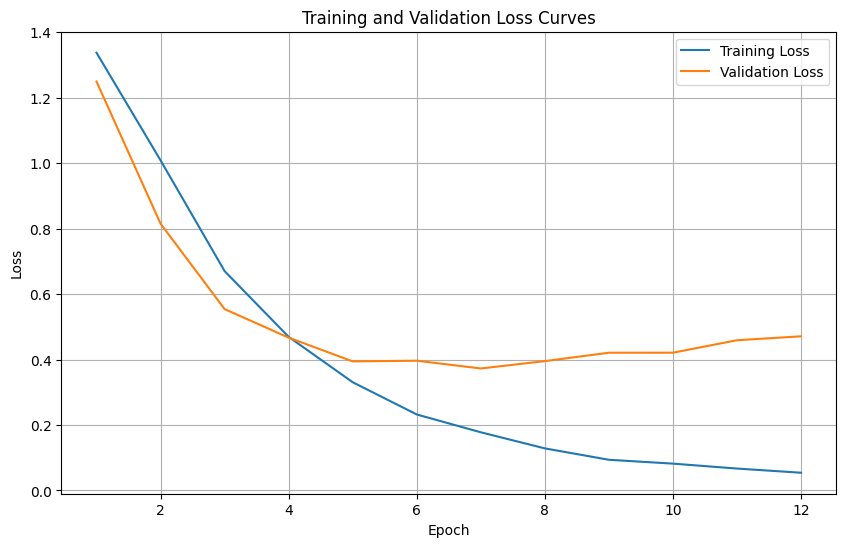

In [39]:
# plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()

Test Loss: 0.3243, Test Accuracy: 89.16%


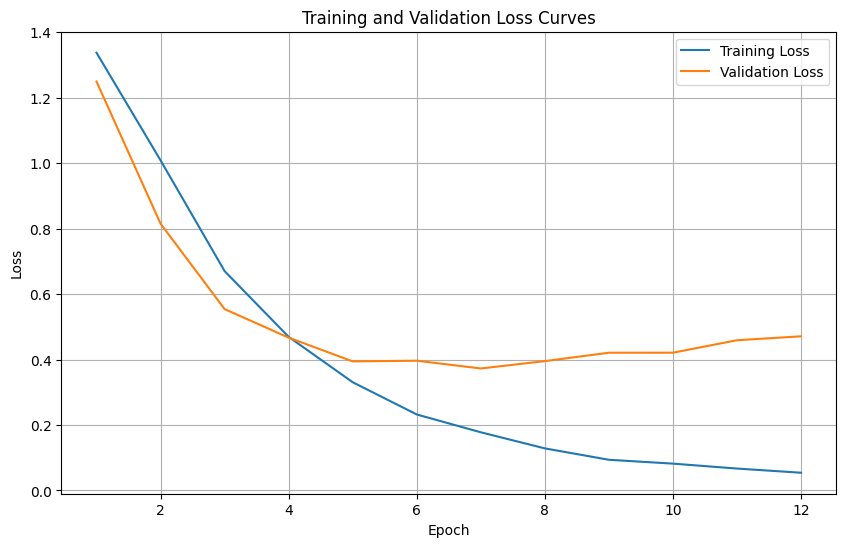


Classification Report:
               precision    recall  f1-score   support

       angry       0.98      0.86      0.92       140
       happy       0.90      0.97      0.94       148
     relaxed       0.81      0.90      0.86       146
         sad       0.89      0.83      0.86       138

    accuracy                           0.89       572
   macro avg       0.90      0.89      0.89       572
weighted avg       0.90      0.89      0.89       572



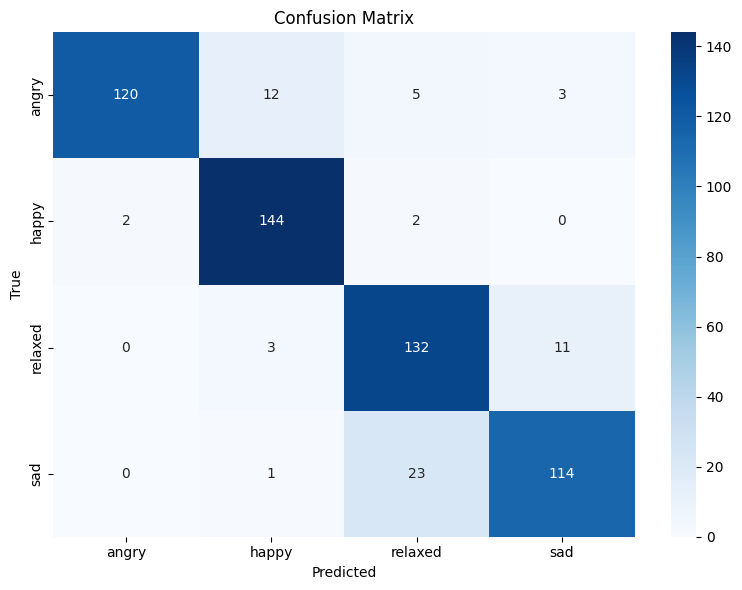

In [40]:
# load best model from training 
final_model.load_state_dict(torch.load(best_model_path)) 
final_model.to(device) 
final_model.eval() 
 
# initialise metrics 
correct = 0 
total = 0 
test_loss = 0.0 
all_preds = [] 
all_labels = [] 
 
with torch.no_grad(): 
    for images, labels in FULL_TEST_LOADER: 
        images, labels = images.to(device), labels.to(device) 
        outputs = final_model(images) 
        # for test loss 
        loss = criterion(outputs, labels) 
        test_loss += loss.item() * images.size(0) 
        # for accuracy 
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 
 
        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu 
        all_labels.extend(labels.cpu().numpy()) 
 
test_loss = test_loss / len(FULL_TEST_LOADER.dataset) 
test_accuracy = correct / total 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%") 
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100) 
 
# plotting training and validation loss curves 
if 'train_losses' in globals() and 'val_losses' in globals(): 
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss") 
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss") 
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training and Validation Loss Curves") 
    plt.legend() 
    plt.grid(True) 
    loss_curve_path = os.path.join("..", "results", "efficientnetb5", "loss_curves.png") #NOTE: specify by model name 
    plt.savefig(loss_curve_path) 
    plt.show() 
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path) 
else: 
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.") 
 
# generate and log classification report 
class_names = FULL_TEST_LOADER.dataset.classes 
report = classification_report(all_labels, all_preds, target_names=class_names) 
print("\nClassification Report:\n", report) 
logging.info("Classification Report:\n%s", report) 
 
# generate confusion matrix 
cm = confusion_matrix(all_labels, all_preds) 
 
# save confusion matrix as image 
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax) 
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.title("Confusion Matrix") 
plt.tight_layout() 
 
conf_matrix_path = os.path.join("..", "results", "efficientnetb5", "confusion_matrix.png") #NOTE: specify by model name 
fig.savefig(conf_matrix_path) 
plt.show(fig) 
 
logging.info("Confusion matrix saved to: %s", conf_matrix_path)
